In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage

charger les donnees:

In [3]:
data=pd.read_csv("Mall_Customers.csv")


L'appercu


In [4]:
print(data.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [6]:
print (data.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [13]:
print(data.shape)

(198, 4)


In [7]:
print("Valeurs manquantes :\n", data.isnull().sum())

Valeurs manquantes :
 CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


nettoyage :

supprimer l ID inutile

In [8]:
data = data.drop("CustomerID", axis=1)

In [10]:
#encoder le genre
data["Genre"] = data["Genre"].map({"Male": 0, "Female": 1})

In [11]:
print(data.head())

   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0      0   19                  15                      39
1      0   21                  15                      81
2      1   20                  16                       6
3      1   23                  16                      77
4      1   31                  17                      40


Détection et traitement des outliers

In [12]:
#Méthode IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Supprimer outliers sur Age, Income et Spending
data = remove_outliers(data, ["Age", "Annual Income (k$)", "Spending Score (1-100)"])

print("Taille après suppression des outliers :", data.shape)


Taille après suppression des outliers : (198, 4)


Matrice de corrélation

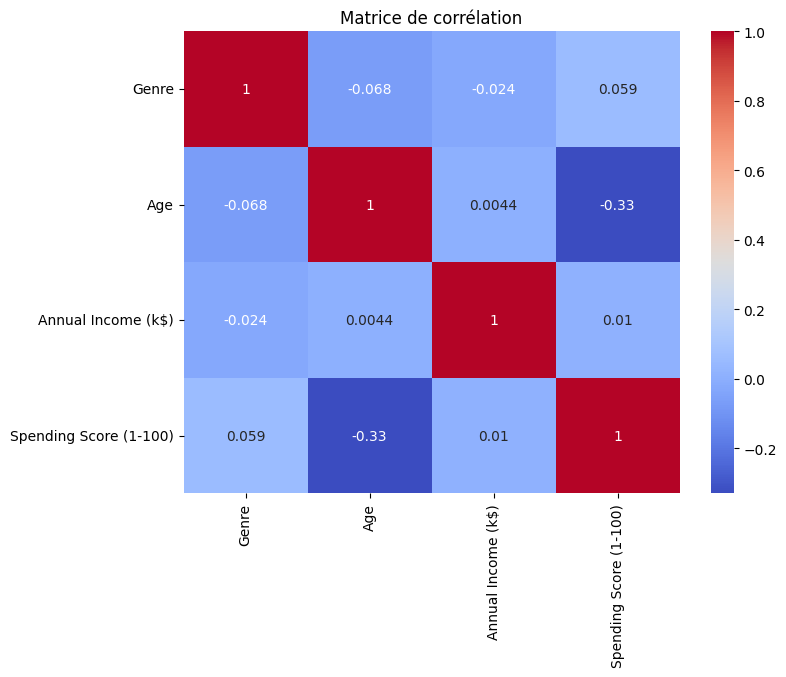

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

print(X_scaled[:5])


[[-1.1411948  -1.42541358 -1.77917141 -0.43598941]
 [-1.1411948  -1.2823665  -1.77917141  1.19941337]
 [ 0.87627458 -1.35389004 -1.73944701 -1.72094874]
 [ 0.87627458 -1.13931942 -1.73944701  1.04366072]
 [ 0.87627458 -0.5671311  -1.69972262 -0.39705125]]


In [16]:
pca = PCA(n_components=2)  # On réduit à 2D pour visualisation
X_pca = pca.fit_transform(X_scaled)

print("Variance expliquée :", pca.explained_variance_ratio_)



Variance expliquée : [0.33807564 0.25402715]


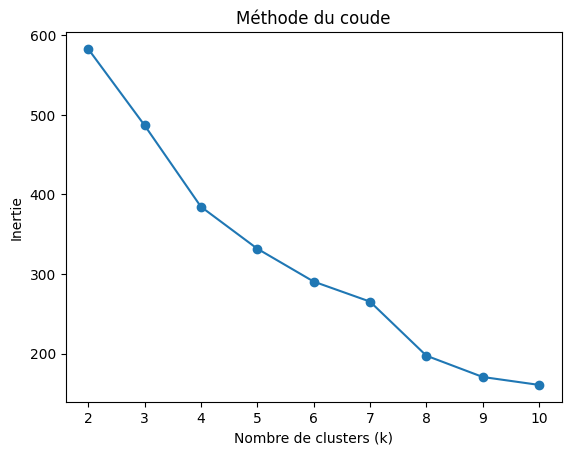

In [17]:
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.show()


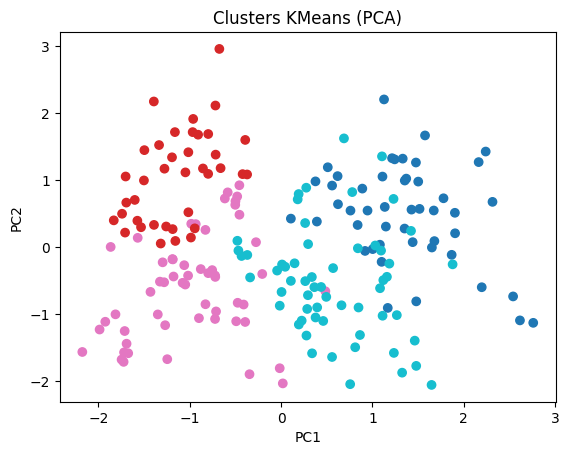

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

data["Cluster_KMeans"] = clusters_kmeans

# Visualiser en PCA
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap="tab10")
plt.title("Clusters KMeans (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


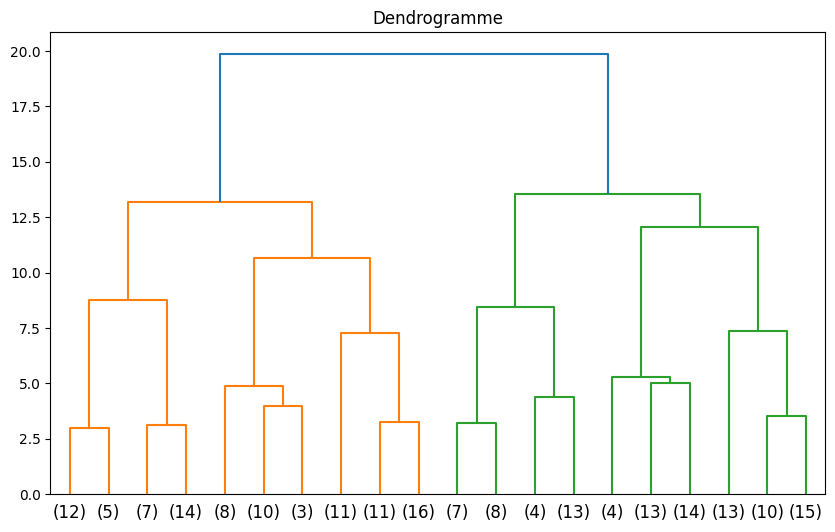

In [24]:
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode="lastp", p=20)
plt.title("Dendrogramme")
plt.show()

hc = AgglomerativeClustering(n_clusters=5, linkage="ward")
clusters_hc = hc.fit_predict(X_scaled)

data["Cluster_HC"] = clusters_hc


In [25]:
data["Income_per_Age"] = data["Annual Income (k$)"] / (data["Age"] + 1)
data["Spending_Ratio"] = data["Spending Score (1-100)"] / (data["Annual Income (k$)"] + 1)

print(data.head())


   Genre  Age  Annual Income (k$)  Spending Score (1-100)  Cluster_KMeans  \
0      0   19                  15                      39               2   
1      0   21                  15                      81               2   
2      1   20                  16                       6               2   
3      1   23                  16                      77               2   
4      1   31                  17                      40               2   

   Cluster_HC  Income_per_Age  Spending_Ratio  
0           0        0.750000        2.437500  
1           0        0.681818        5.062500  
2           3        0.761905        0.352941  
3           0        0.666667        4.529412  
4           3        0.531250        2.222222  


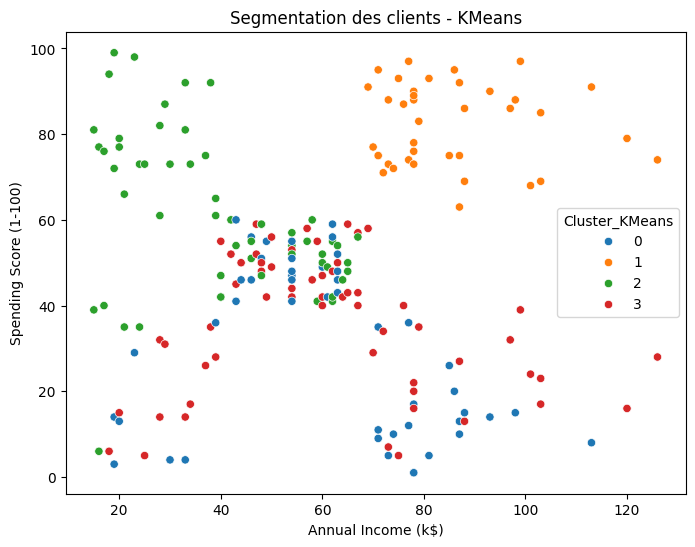

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)",
                hue="Cluster_KMeans", data=data, palette="tab10")
plt.title("Segmentation des clients - KMeans")
plt.show()


The clustering has identified four distinct customer segments:

Cluster 0 (Blue): Customers with moderate to high income ($40-120k) but low spending scores (0-40). These might be "Cautious/Conservative spenders" - they have money but prefer to save rather than spend.
Cluster 1 (Orange): High-income customers ($60-120k) with high spending scores (60-100). These are likely "High-value customers" - affluent individuals who spend freely.
Cluster 2 (Green): Low to moderate income ($15-40k) with high spending scores (60-100). These could be "Aspirational spenders" - customers who spend a lot relative to their income.
Cluster 3 (Red): Low to moderate income ($15-70k) with low spending scores (0-50). These are probably "Budget-conscious customers" - those with limited income who spend carefully.

This segmentation is valuable for targeted marketing strategies. For example:

Target luxury products to Cluster 1
Offer value deals to Cluster 3
Focus on aspirational/trendy products for Cluster 2
Provide investment/savings products to Cluster 0

The clear separation between clusters suggests this is an effective segmentation for business decision-making.RéessayerClaude peut faire des erreurs. Assurez-vous de vérifier ses réponses.